In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv
/kaggle/input/heart-attack-engineered-dataset-1/heart_attack_engineered_dataset_1.csv


# Here we will model tree-based models

### These include:
* Random Forest
* XGBoost
* Adaboost

## Prepare Data

In [2]:
heart_data = pd.read_csv("../input/heart-attack-engineered-dataset-1/heart_attack_engineered_dataset_1.csv")

In [3]:
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
# Split data in half, one training set, and one test set
X_train, X_test, y_train, y_test = train_test_split(heart_data.drop(columns=['output']),
                                                    heart_data['output'], 
                                                    test_size=0.5, 
                                                    random_state=125)

## Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Hyperparameter Optimization for Random Forest

In [6]:
param_grid = {'max_depth': [10,20,30,40,50],
             'n_estimators': [100,200,300,400,500],
             'max_leaf_nodes':[5,10,20]}

In [7]:
# model = RandomForestClassifier()
# grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_log_error', cv=10)

In [8]:
# %%time
# grid.fit(X_train, y_train)

In [9]:
# grid.best_params_

**End of hyperparameter optimization**

*Best Parameters:* {'max_depth': 10, 'max_leaf_nodes': 20, 'n_estimators': 100}

Now build model with best parameters.

In [10]:
model = RandomForestClassifier(max_depth=10, 
                               max_leaf_nodes=20,
                               n_estimators=100)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=20)

In [11]:
predictions = model.predict(X_test)

#### Analysis of Performance for Random Forest

* confusion_matrix
* classification_report

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [13]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82        72
           1       0.82      0.88      0.85        80

    accuracy                           0.84       152
   macro avg       0.84      0.83      0.83       152
weighted avg       0.84      0.84      0.84       152



In [14]:
conf_matrix = confusion_matrix(y_test, predictions)

In [15]:
import matplotlib.pyplot as plt

In [16]:
# plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Greens)

Text(0.5, 1.0, 'Confusion Matrix for RandomForestClassifier Prediction')

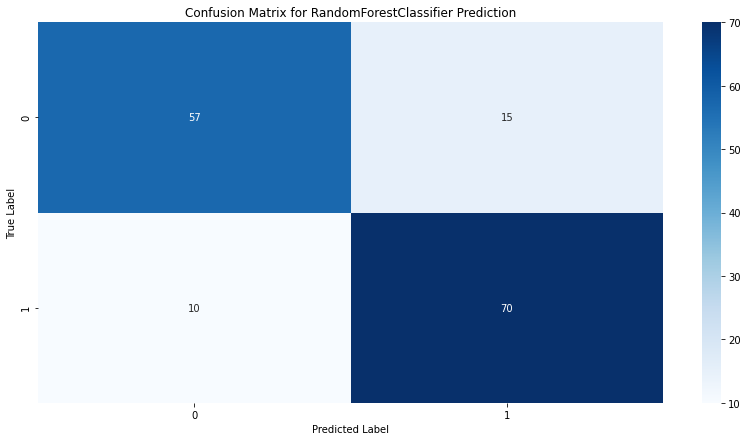

In [17]:
import seaborn as sns

plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RandomForestClassifier Prediction")

## XGBoost

In [18]:
from xgboost import XGBClassifier

### Hyperparameter Optimization

Help on how to do this for XGBoost found here: [Hyperparameter Optimization for Xgboost](https://www.youtube.com/watch?v=9HomdnM12o4)

This notebook also helped: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [19]:
xgb_param_grid = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [20]:
# xgb_model = XGBClassifier()
xgb_model = XGBClassifier(learning_rate=0.02, 
                          n_estimators=600, 
                          objective='binary:logistic',
                          use_label_encoder=False,
#                           silent=True, 
                          nthread=1)
# grid = GridSearchCV(xgb_model, xgb_param_grid, scoring='neg_mean_squared_log_error', cv=10)

grid = GridSearchCV(xgb_model, xgb_param_grid, scoring='roc_auc', cv=10)

randomized_search = RandomizedSearchCV(xgb_model, xgb_param_grid, scoring='roc_auc', cv=10)

In [21]:
# %%time
# grid.fit(X_train, y_train)


# randomized_search.fit(X_train, y_train)

In [22]:
# grid.best_params_
# randomized_search.best_params_

**End of hyperparameter optimization for XGBoost**

Used RandomizedSearchCV, took 44s
note: grid search takes much longer, an hour or more

using scoring='roc_auc'
*Best Parameters:* {'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.5}
 
 
 *Best Paramters 2* (using scoring='neg_mean_squared_log_error' ): {'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

Now build model with best parameters.

In [23]:
xgb_model = XGBClassifier(max_depth= 15,
                          learning_rate=0.1, 
                          min_child_weight=1, 
                          gamma=0.0, 
                          colsample_bytree=0.5, 
                          n_estimators=600, 
                          objective='binary:logistic',
                          use_label_encoder=False)#, 
#                           nthread=1)

xgb_model.fit(X_train, y_train)

[13:31:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
xgb_predictions = xgb_model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [25]:
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        72
           1       0.80      0.88      0.83        80

    accuracy                           0.82       152
   macro avg       0.82      0.81      0.81       152
weighted avg       0.82      0.82      0.81       152



In [26]:
conf_matrix = confusion_matrix(y_test, xgb_predictions)

Text(0.5, 1.0, 'Confusion Matrix for XGBoost Classifier Prediction')

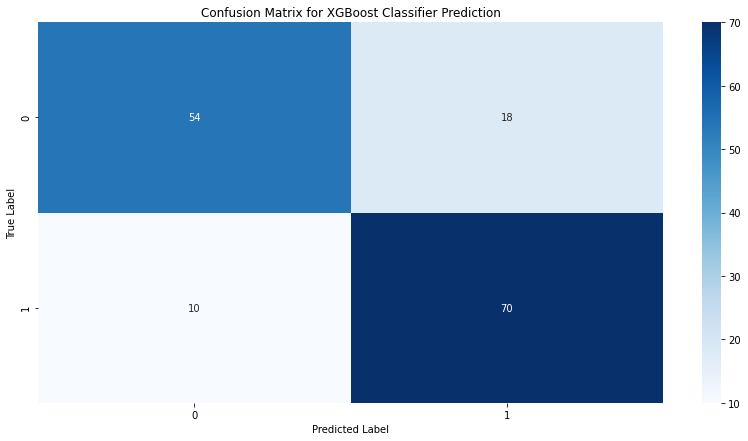

In [27]:
plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Classifier Prediction")

## Adaboost

In [28]:
from sklearn.ensemble import AdaBoostClassifier

#### Hyperparameter Optimization for Adaboost

In [29]:
adaboost_param_grid = {
 "learning_rate"    : [0.0001, 0.001, 0.01, 0.1, 1.0] ,
 "n_estimators"        : [10, 50, 100, 500],
}

In [30]:
adaboost_model = AdaBoostClassifier()
ada_grid = GridSearchCV(adaboost_model, adaboost_param_grid, scoring='neg_mean_squared_log_error', cv=10)

In [31]:
# %%time
# ada_grid.fit(X_train, y_train)

In [32]:
# ada_grid.best_params_

**End of hyperparameter optimization for AdaBoost**

grid search took 1min 34s

note: grid search takes much longer, an hour or more

*Best Parameters:* {'learning_rate': 0.1, 'n_estimators': 50}

Now build model with best parameters.

In [33]:
adaboost_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=50)

adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1)

In [34]:
adaboost_predictions = adaboost_model.predict(X_test)

In [35]:
print(classification_report(y_test, adaboost_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        72
           1       0.77      0.82      0.80        80

    accuracy                           0.78       152
   macro avg       0.78      0.77      0.77       152
weighted avg       0.78      0.78      0.78       152



In [36]:
conf_matrix = confusion_matrix(y_test, adaboost_predictions)

Text(0.5, 1.0, 'Confusion Matrix for AdaBoost Classifier Prediction')

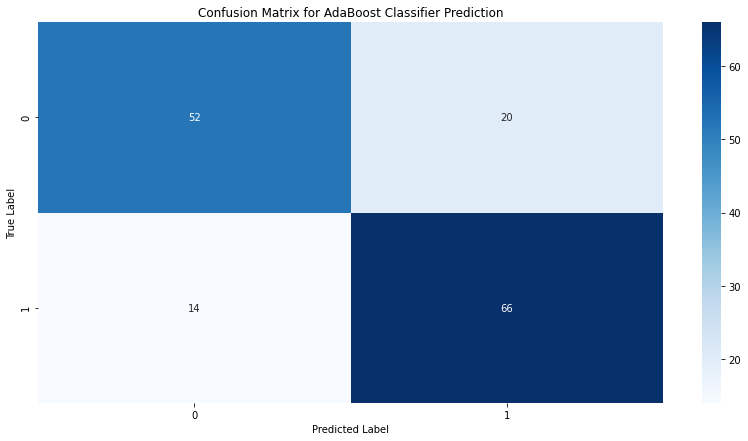

In [37]:
plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for AdaBoost Classifier Prediction")